In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import json
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from PIL import Image, UnidentifiedImageError
import nltk
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import csr_matrix, hstack

In [36]:
train_data = pd.read_excel('train_Turkey.xlsx')
jakarta_data = pd.read_csv('jakarta_fitness_area_all_features.csv')
jakarta_data['area_building_osm_known']=jakarta_data['area_building_osm'].fillna(0)*jakarta_data['intersect_building_osm']
jakarta_data['years_presence'] = jakarta_data['oldest_days'] /365
jakarta_data['review_freq_per_month'] = jakarta_data.apply(lambda row: row['review_count'] / row['oldest_days'] * 30 if row['oldest_days'] > 0 else 0, axis = 1)

In [18]:
jakarta_data['area_building_osm_known'].describe()

count     1698.000000
mean      1862.916732
std       6039.626478
min          0.000000
25%          0.000000
50%         85.692298
75%        498.571922
max      60026.657897
Name: area_building_osm_known, dtype: float64

In [19]:
train_data['area_building_osm_known'].describe()

count      1975.000000
mean       2852.730177
std        8294.492088
min          95.214440
25%         451.279238
50%         731.305888
75%        1497.085859
max      113388.310385
Name: area_building_osm_known, dtype: float64

### Rescaling под тренировочные данные (Турция)

In [20]:
scaling_factors = {}

features_1 = [
    # 'area_building_osm_known',
    'oldest_days',
    'review_count',
    'floor_14_p',
    'floor_12_p',
    'floor_34_p',
    'wall_12_p',
    'wall_34_p',
    'floor_14_std',
    'floor_12_std',
    'wall_14_std',
    'wall_34_std',
    'wall_34_sum_norm',
]

jakarta_stats_1 = jakarta_data[features_1].describe().T['50%']
train_stats_1 = train_data[features_1].describe().T['50%']

for feature in features_1:
    scaling_factors[feature] = (train_stats_1[feature] / jakarta_stats_1[feature]).item()

features_2 = [
    'large_room_count',
    # 'group_studio',
    # 'category_complex',
    # 'category_yoga',
    # 'pool',
    # 'sauna',
]

jakarta_stats_2 = jakarta_data[features_2].describe().T['mean']
train_stats_2 = train_data[features_2].describe().T['mean']

for feature in features_2:
    scaling_factors[feature] = (train_stats_2[feature] / jakarta_stats_2[feature]).item()

print(scaling_factors)

jakarta_data_rescaled = jakarta_data.copy()
for feature, factor in scaling_factors.items():
    jakarta_data_rescaled[feature] = jakarta_data[feature] * factor

{'oldest_days': 1.5, 'review_count': 1.6875, 'floor_14_p': 1.0314407614046601, 'floor_12_p': 1.0364361932853303, 'floor_34_p': 1.0250412570854561, 'wall_12_p': 0.9661616161616161, 'wall_34_p': 0.9926832512970599, 'floor_14_std': 0.8915343915343916, 'floor_12_std': 0.971246108918199, 'wall_14_std': 0.9985582420496163, 'wall_34_std': 1.0045948484035416, 'wall_34_sum_norm': 1.0095608692742346, 'large_room_count': 0.6147548651073841}


In [21]:
start_time = time.time()

train_data['target_class'] = train_data['target_area'].apply(lambda x: 1 if x>=1000 else 0)
# jakarta_data_rescaled['target_class'] = jakarta_data_rescaled['target_area'].apply(lambda x: 1 if x>=1000 else 0)


df = train_data.copy()

features = [
    'area_building_osm_known',
    'oldest_days',
    'large_room_count',
    'group_studio',
    'category_complex',
    'category_yoga',
    'review_count',
    'floor_14_p',
    'floor_12_p',
    'floor_34_p',
    'wall_12_p',
    'wall_34_p',
    'floor_14_std',
    'floor_12_std',
    'wall_14_std',
    'wall_34_std',
    'wall_34_sum_norm',
    'pool',
    'sauna',
]

X = df[['text_descriptions'] + features]
y = df['target_class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = X_train[features]
X_val_scaled = X_val[features]

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_val_scaled = scaler.transform(X_val_scaled)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=features)

stops_eng = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Zа-яА-ЯёЁ]+\b',
                             stop_words=list(stops_eng),
                             ngram_range=(1, 3), max_df=0.6, min_df=10)

X_train_text = vectorizer.fit_transform(X_train['text_descriptions'])
X_val_text = vectorizer.transform(X_val['text_descriptions'])

additional_features_train = csr_matrix(X_train_scaled.values)
combined_features_train = hstack([X_train_text, additional_features_train]).toarray()

additional_features_val = csr_matrix(X_val_scaled.values)
combined_features_val = hstack([X_val_text, additional_features_val]).toarray()

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)

model = HistGradientBoostingClassifier(
    random_state=42,
    max_iter=500,
    learning_rate=0.1,
    l2_regularization=1,
    min_samples_leaf=12,
    warm_start=True,
    class_weight={0: class_weights[0], 1: class_weights[1]}
)

model.fit(combined_features_train, y_train)

y_pred = model.predict(combined_features_val)
y_proba = model.predict_proba(combined_features_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba[:, 1])

end_time = time.time()
execution_time = end_time - start_time

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Classification Report:')
print(classification_report(y_val, y_pred))
print(f"\nВремя выполнения: {execution_time // 60:.2f} минут")

Accuracy: 0.94
Precision: 0.76
Recall: 0.69
F1 Score: 0.73
ROC AUC: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       765
           1       0.76      0.69      0.73        94

    accuracy                           0.94       859
   macro avg       0.86      0.83      0.85       859
weighted avg       0.94      0.94      0.94       859


Время выполнения: 2.00 минут


### Применяем модель

In [22]:
jakarta_data_rescaled_text = vectorizer.transform(jakarta_data_rescaled['text_descriptions'])
additional_features_jakarta_data_rescaled = scaler.transform(jakarta_data_rescaled[features])

additional_features_jakarta_data_rescaled = csr_matrix(additional_features_jakarta_data_rescaled)
combined_features_jakarta_data_rescaled = hstack([jakarta_data_rescaled_text, additional_features_jakarta_data_rescaled]).toarray()
y_pred = model.predict(combined_features_jakarta_data_rescaled)
jakarta_data_rescaled['class_area'] = y_pred

In [23]:
jakarta_data_rescaled['class_area'].value_counts()

class_area
0    1576
1     122
Name: count, dtype: int64

In [24]:
# студия
jakarta_data_rescaled['class_area'] = np.where(jakarta_data_rescaled['group_studio'] == 1,
                                             0,
                                             jakarta_data_rescaled['class_area'])

# йога
jakarta_data_rescaled['class_area'] = np.where(jakarta_data_rescaled['category_yoga'] == 1,
                                             0,
                                             jakarta_data_rescaled['class_area'])

# площадь здания
jakarta_data_rescaled['area_building_osm_known_0'] = jakarta_data_rescaled['area_building_osm_known'].fillna(0)
jakarta_data_rescaled['class_area'] = np.where(jakarta_data_rescaled['area_building_osm_known_0'] < 300, 
                                               0, 
                                               jakarta_data_rescaled['class_area'])

# бассейн и сауна
jakarta_data_rescaled['class_area'] = np.where((jakarta_data_rescaled['pool'] == 1) & (jakarta_data_rescaled['sauna'] == 1), 
                                               1, 
                                               jakarta_data_rescaled['class_area'])

# отзывы
jakarta_data_rescaled['class_area'] = np.where(jakarta_data_rescaled['review_count'] <= 50, 
                                               0, 
                                               jakarta_data_rescaled['class_area'])


In [25]:
jakarta_data_rescaled['class_area'].value_counts()

class_area
0    1613
1      85
Name: count, dtype: int64

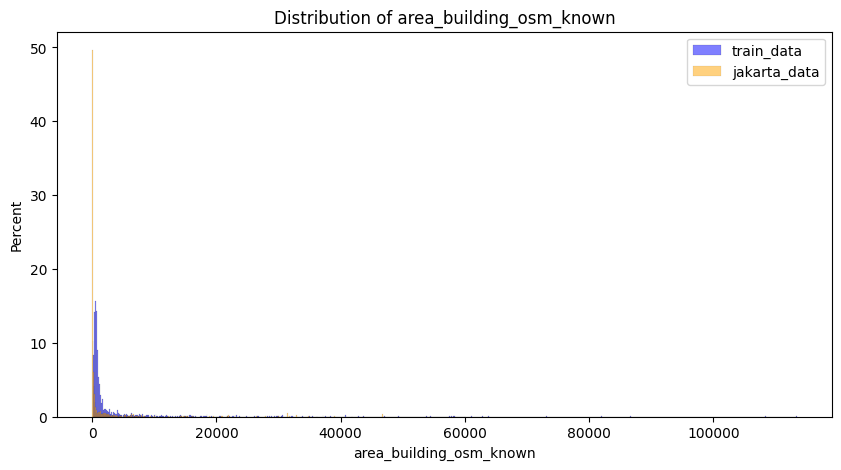

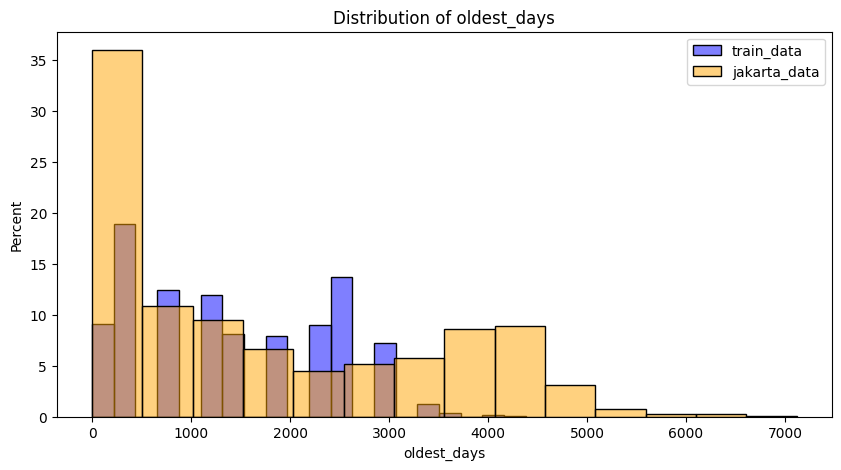

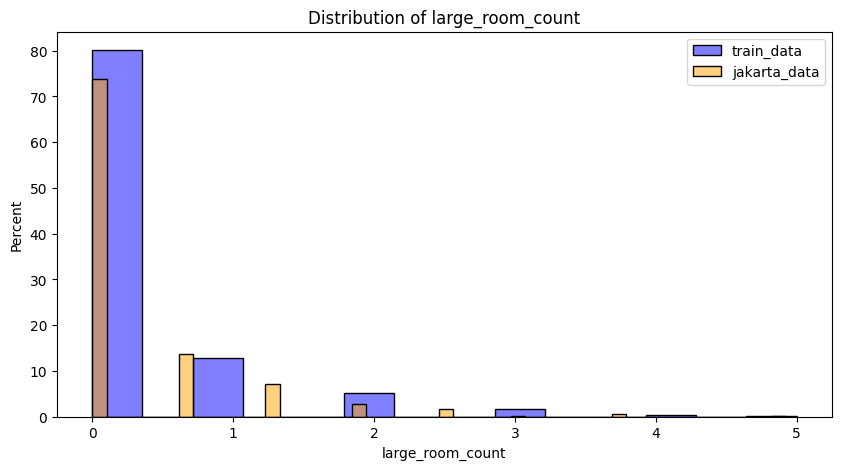

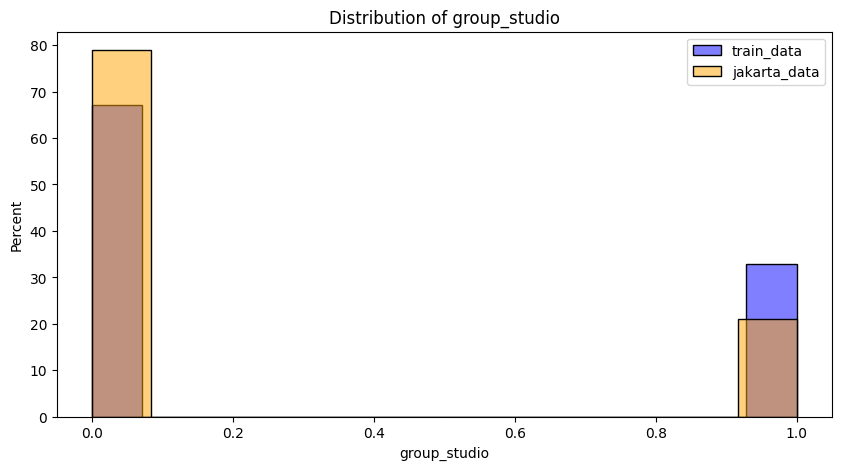

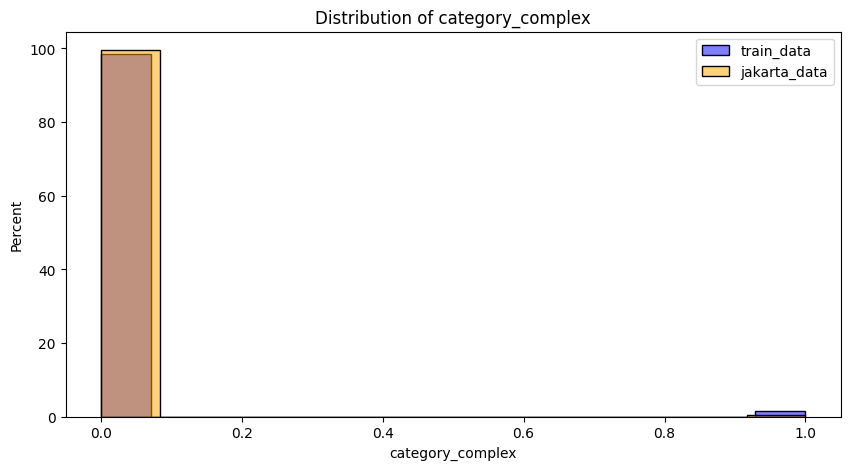

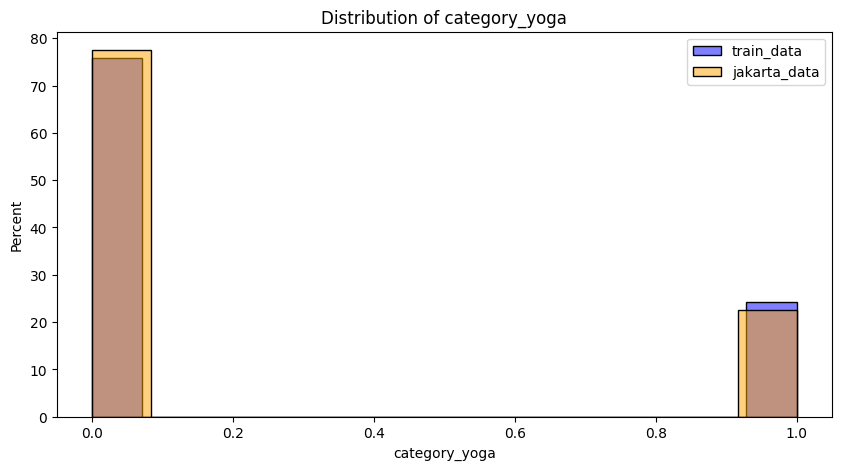

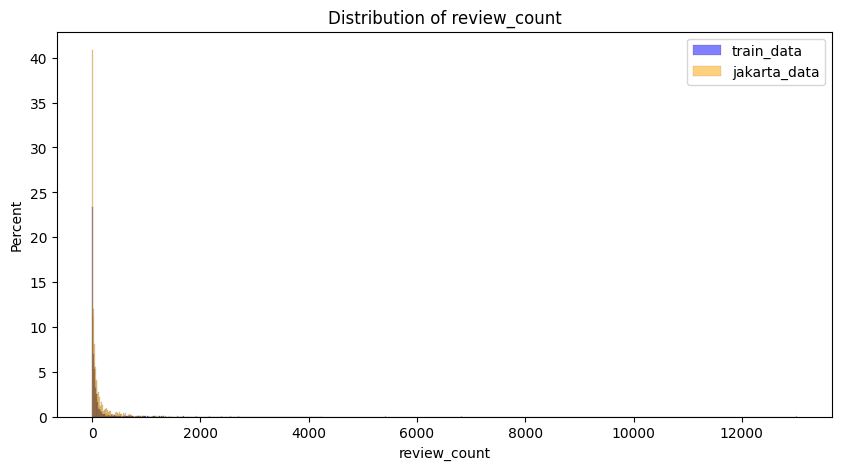

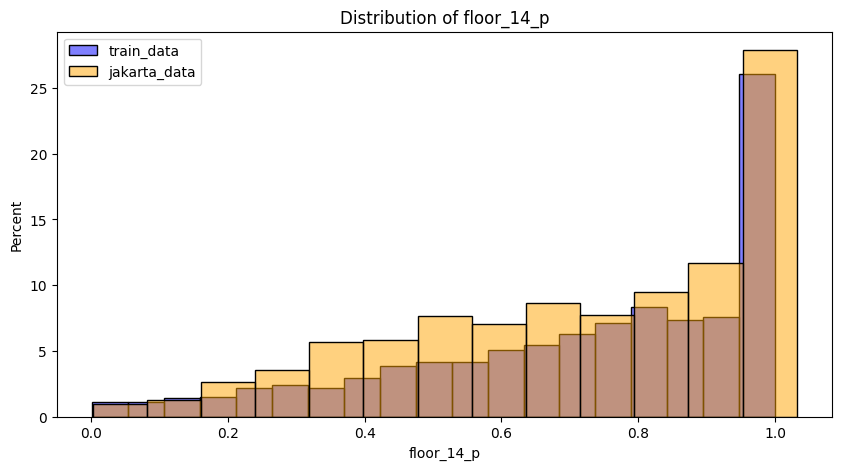

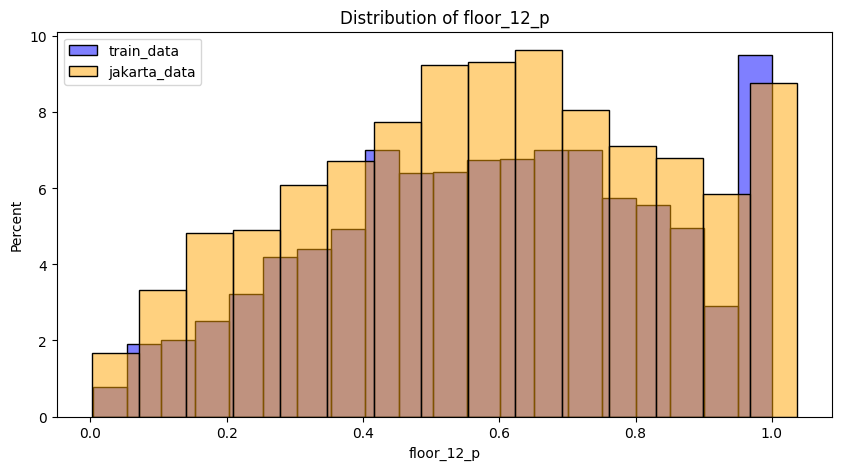

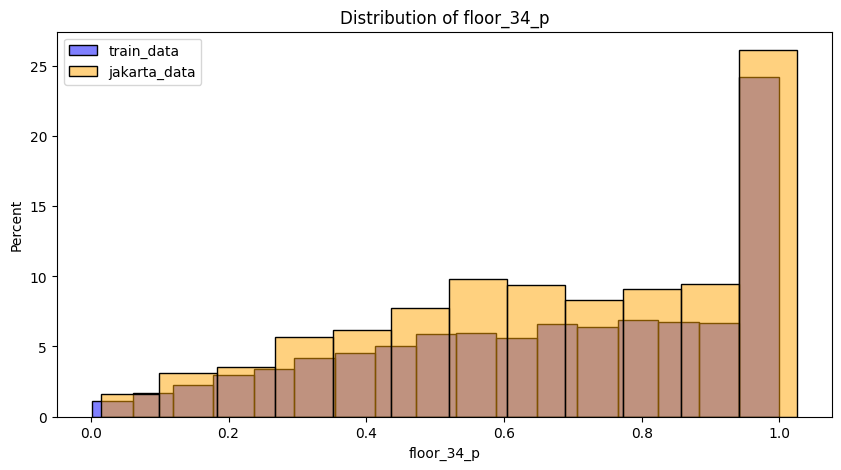

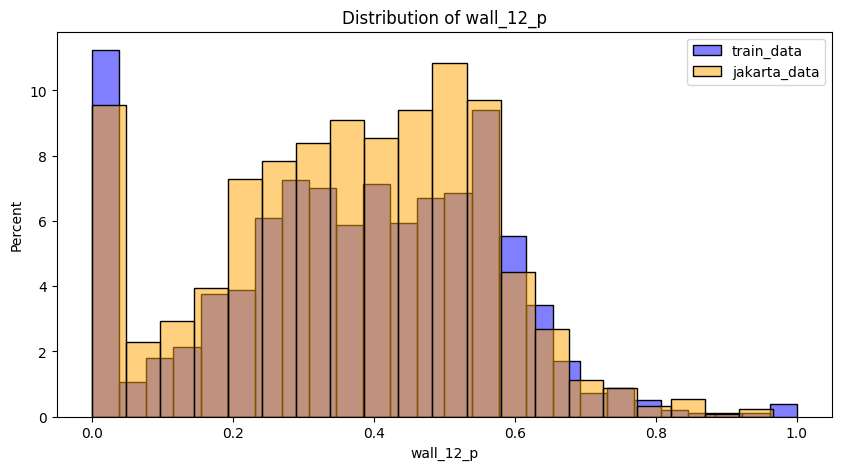

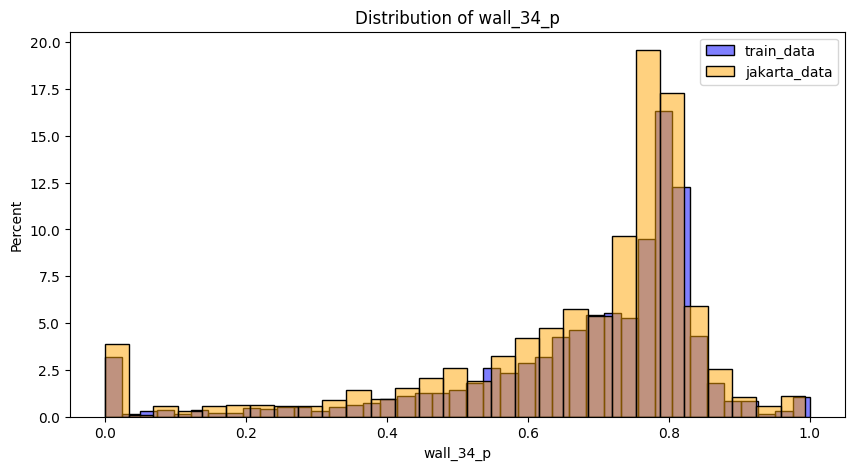

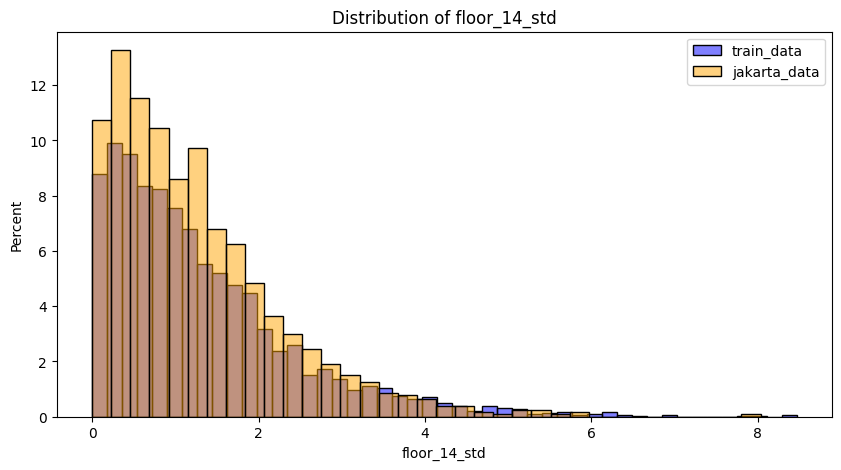

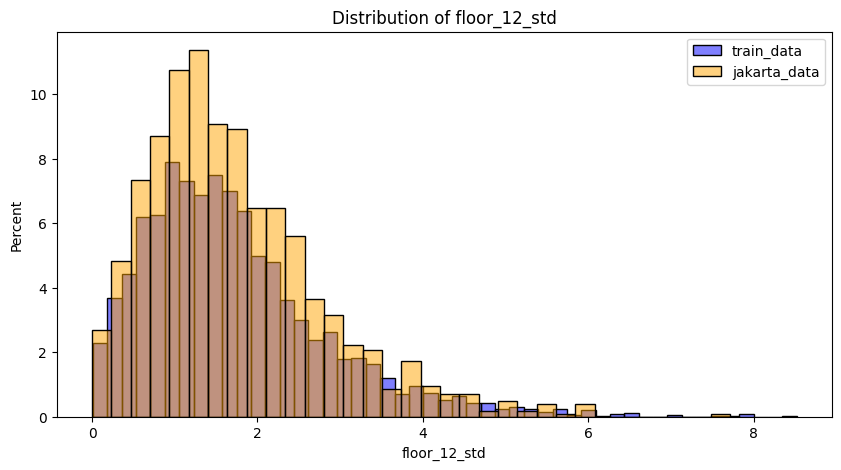

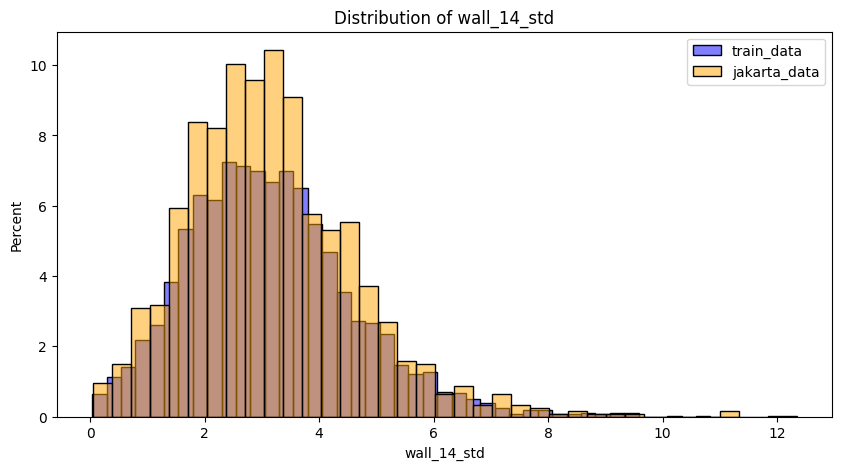

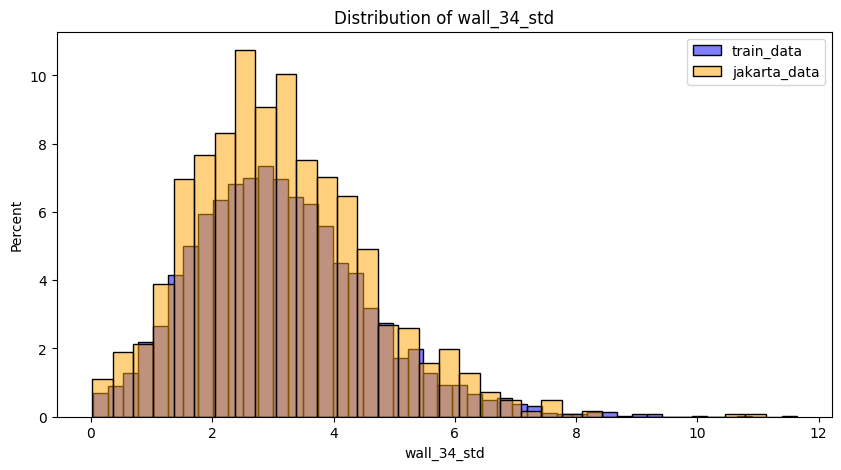

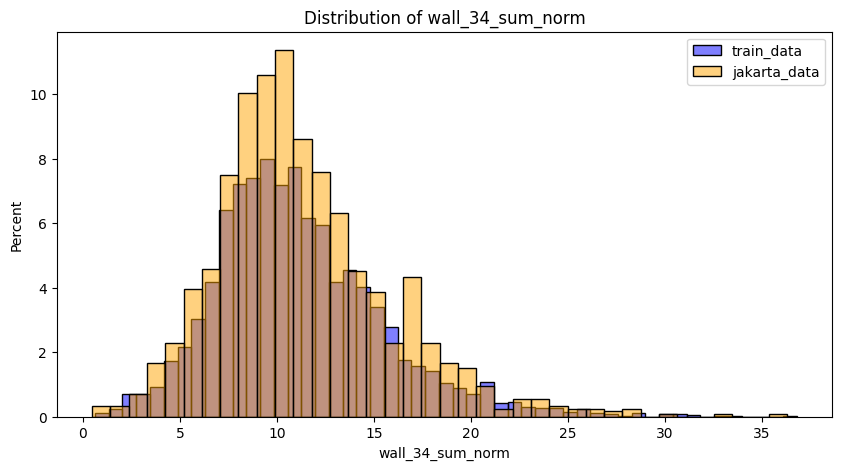

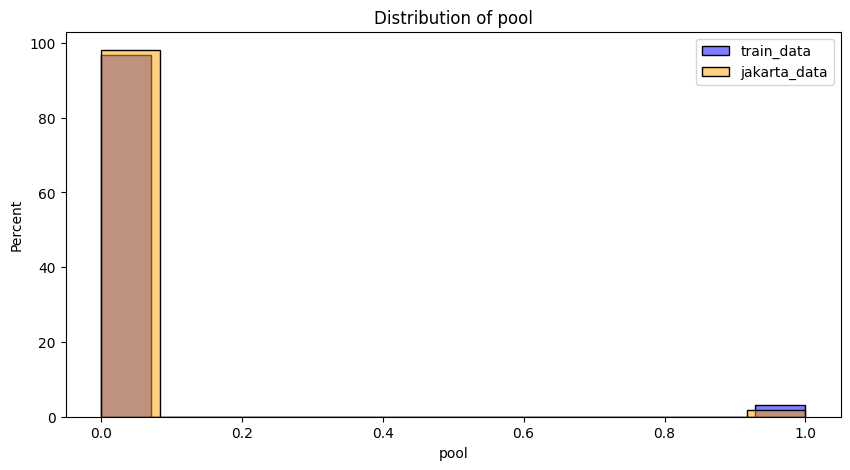

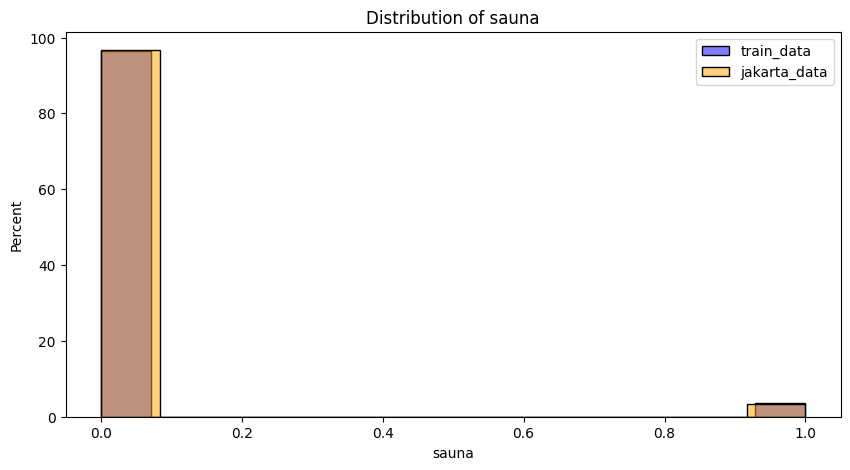

train_data class distribution:
 target_class
0    3793
1     499
Name: count, dtype: int64


KeyError: 'target_class'

In [28]:
# Compare feature distributions
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_data[feature], label='train_data', color='blue', alpha=0.5, stat = 'percent')
    sns.histplot(jakarta_data_rescaled[feature], label='jakarta_data', color='orange', alpha=0.5, stat = 'percent')
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

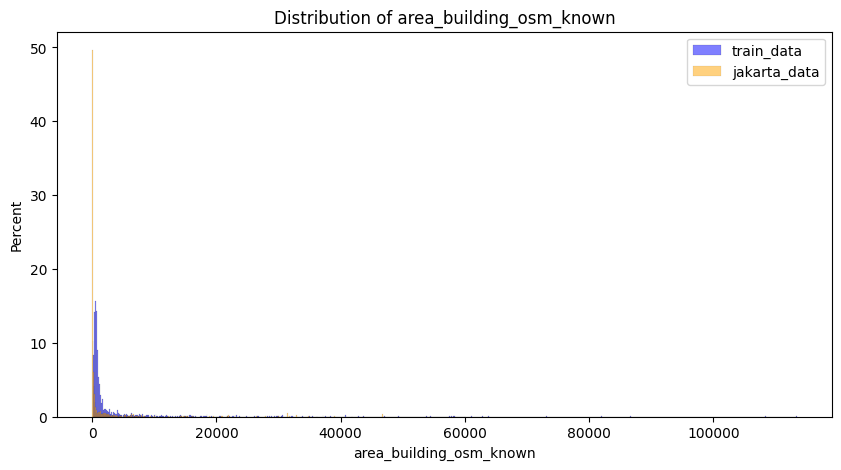

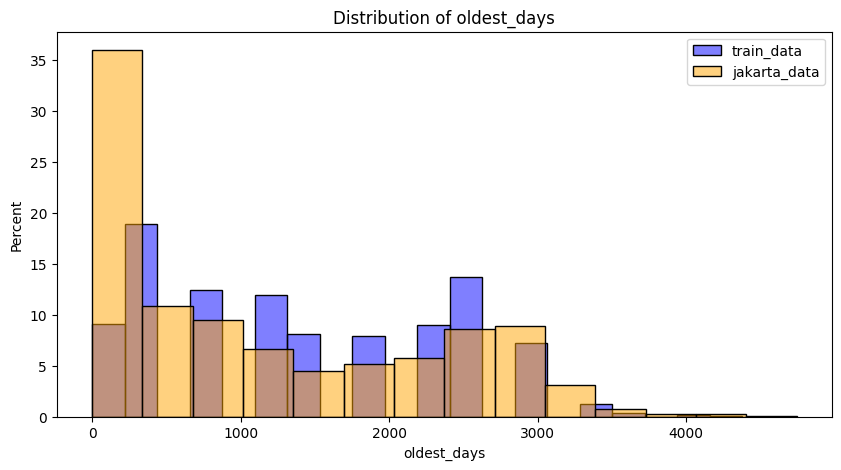

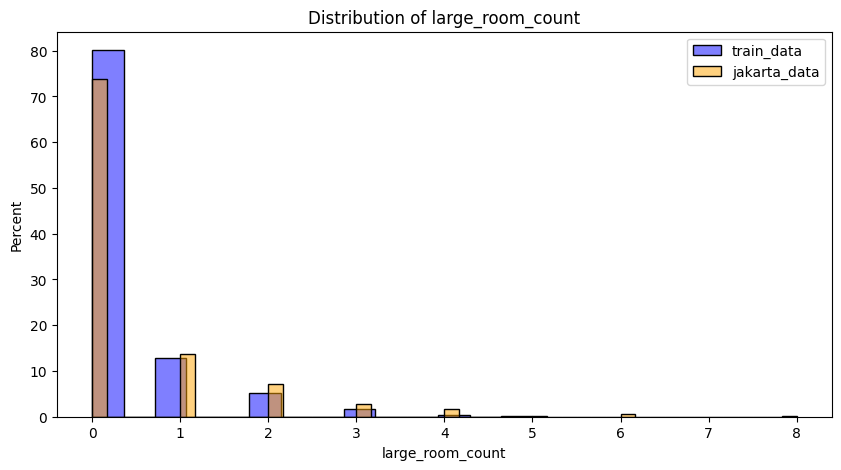

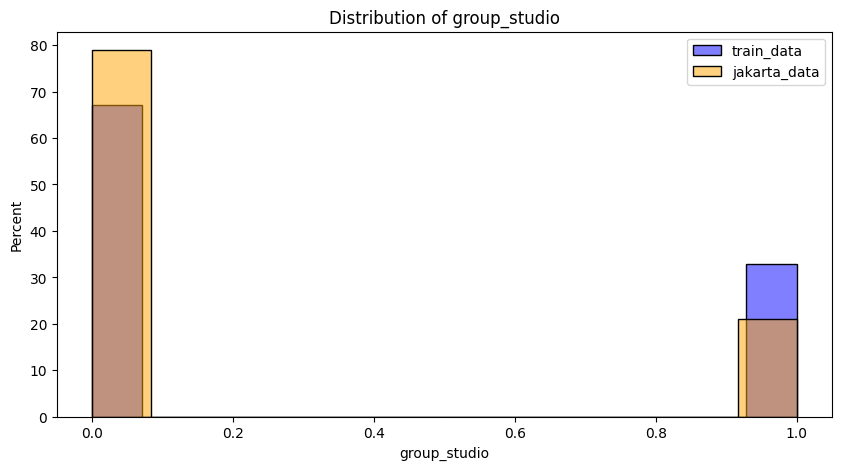

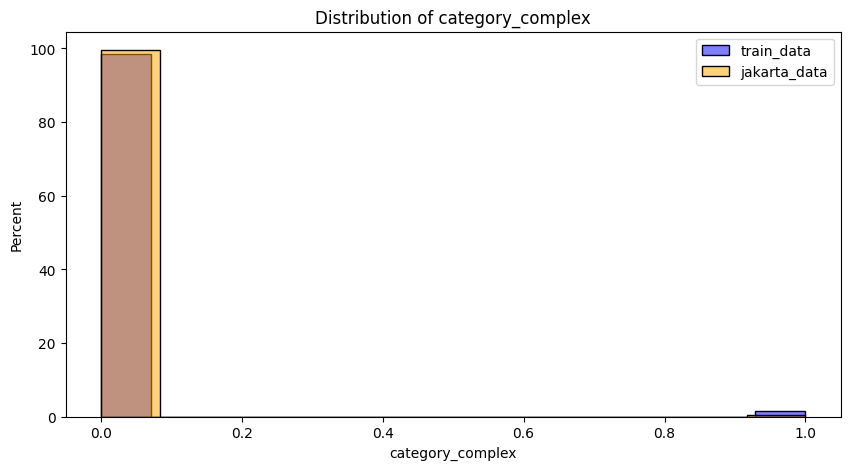

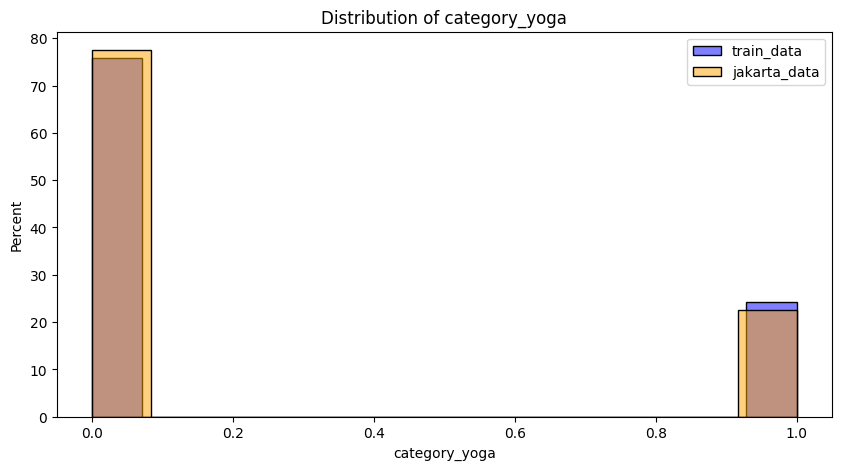

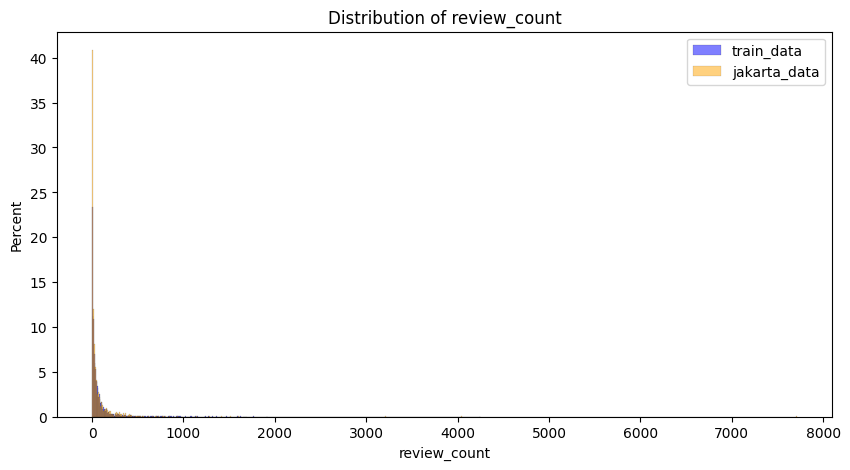

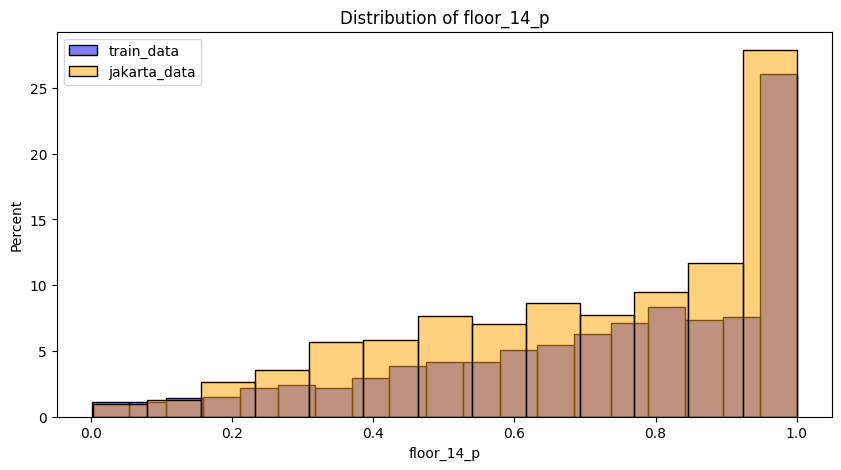

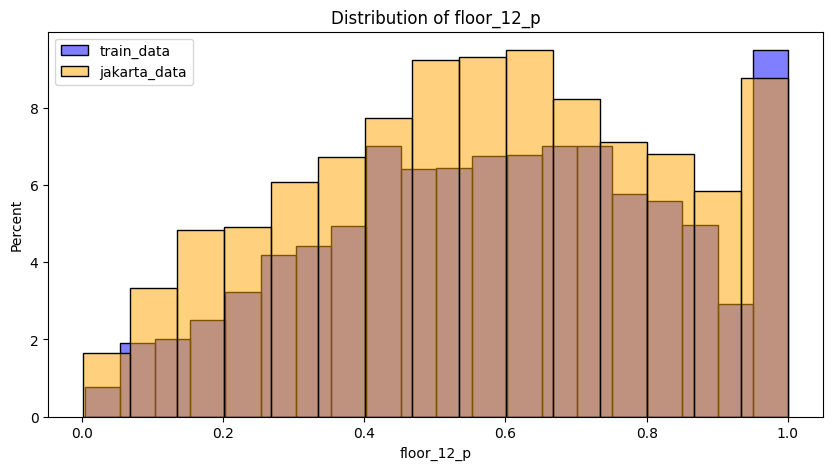

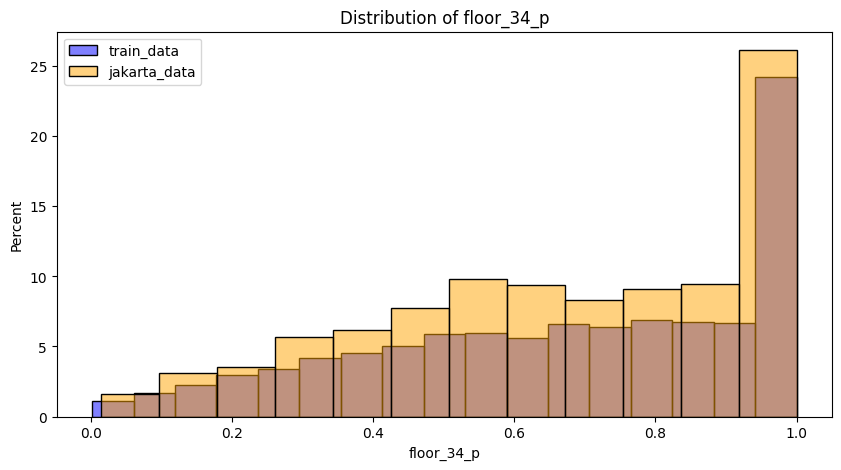

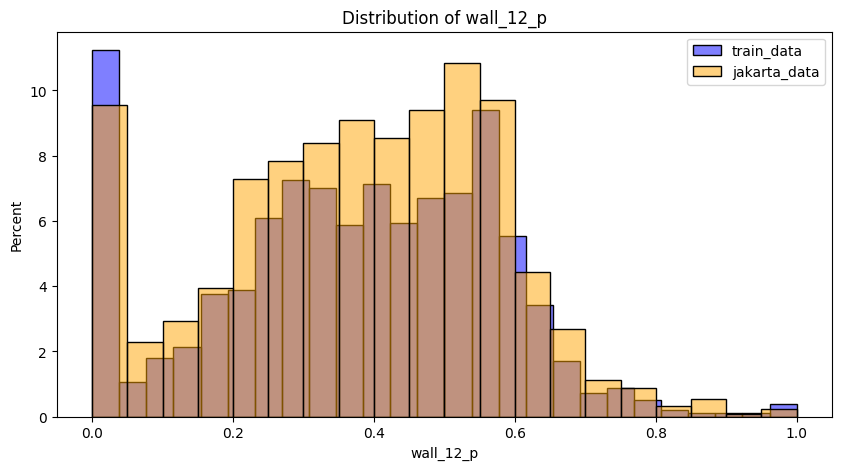

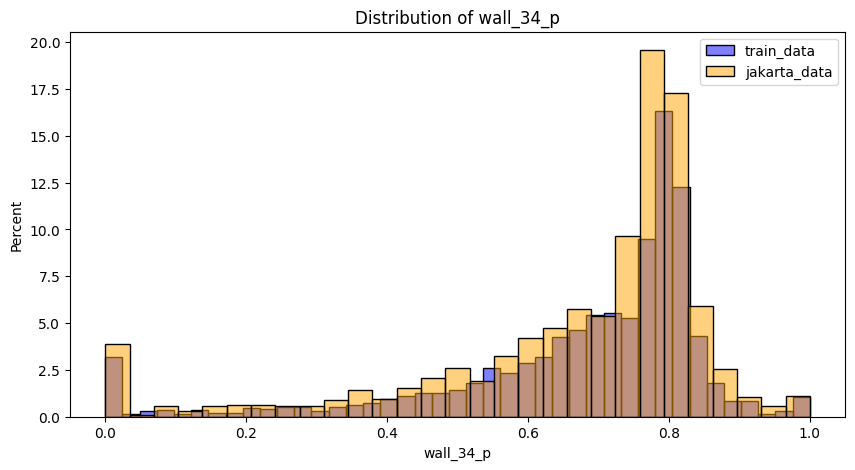

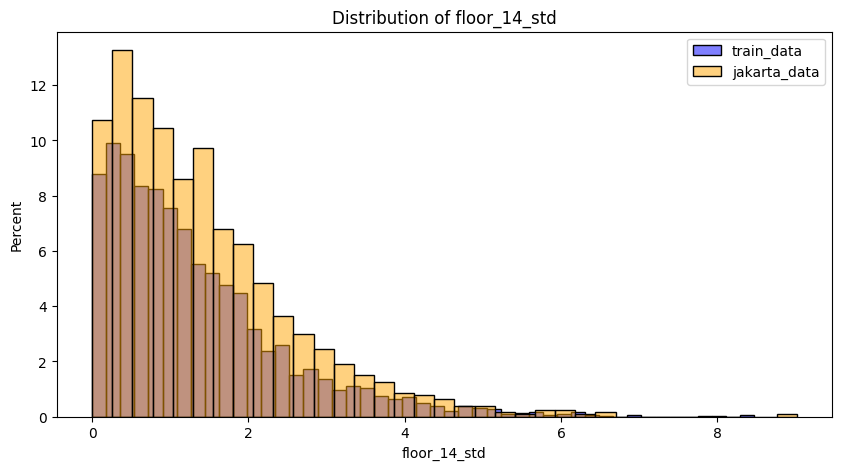

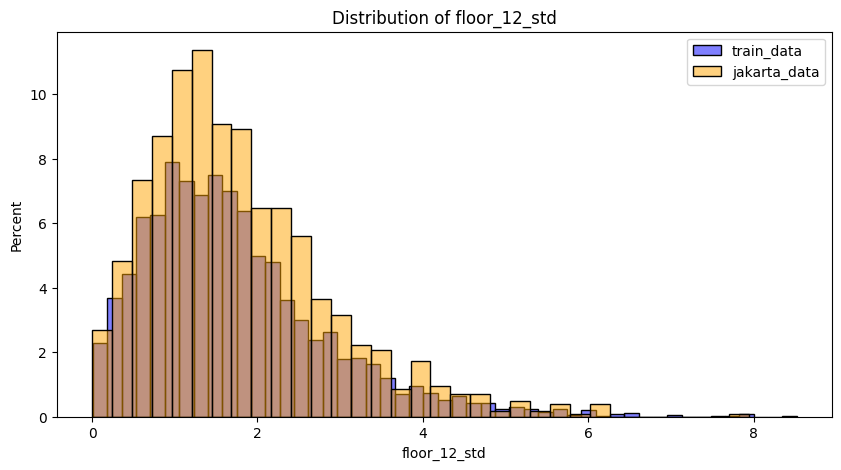

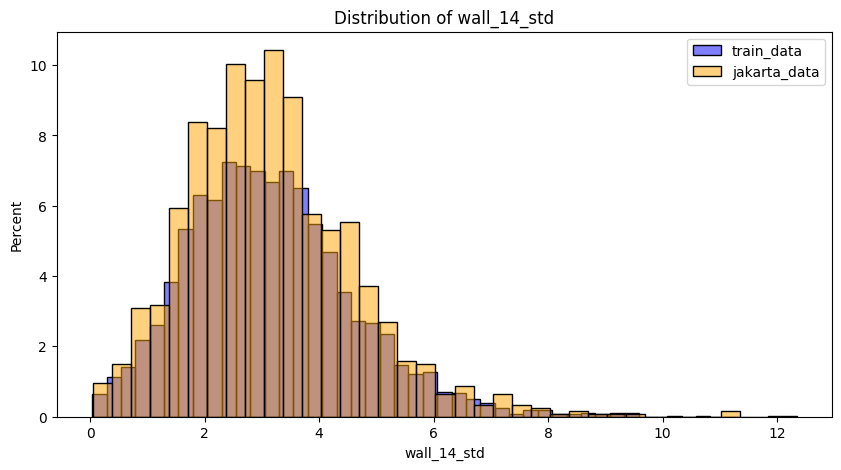

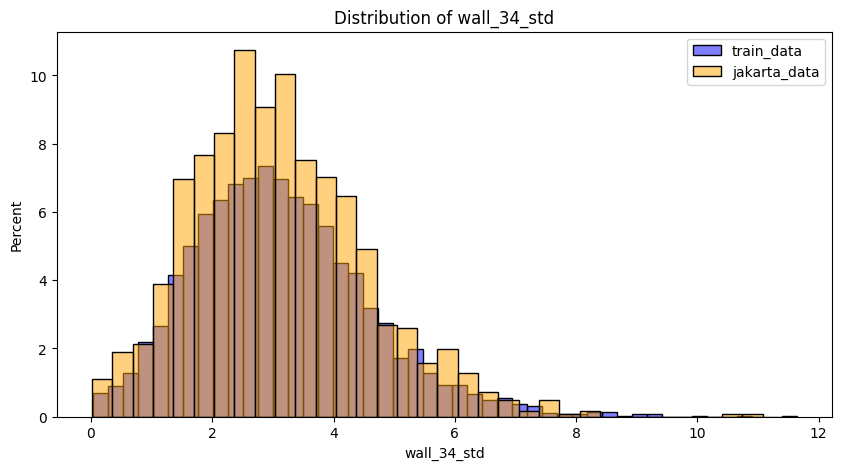

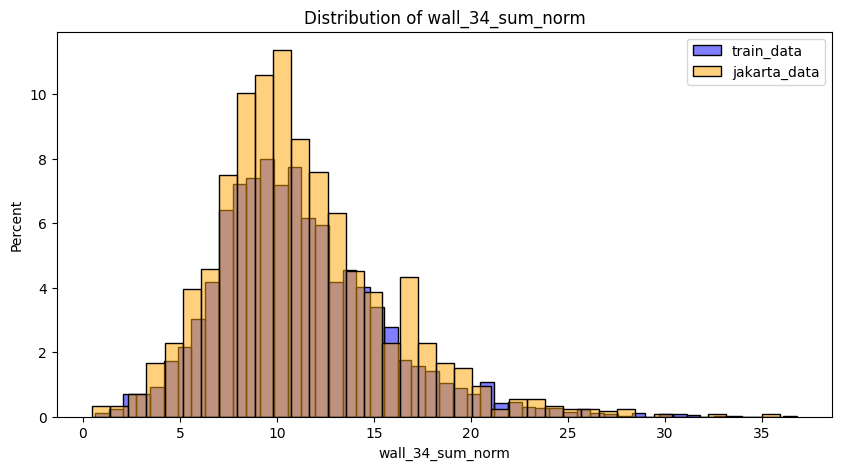

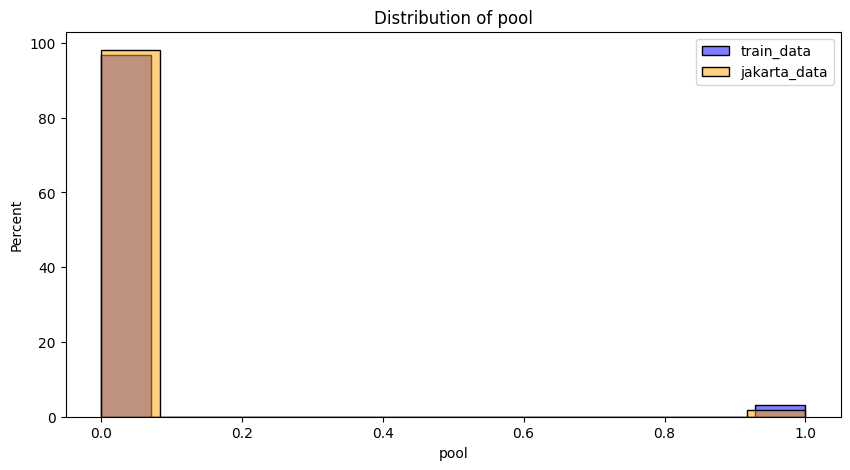

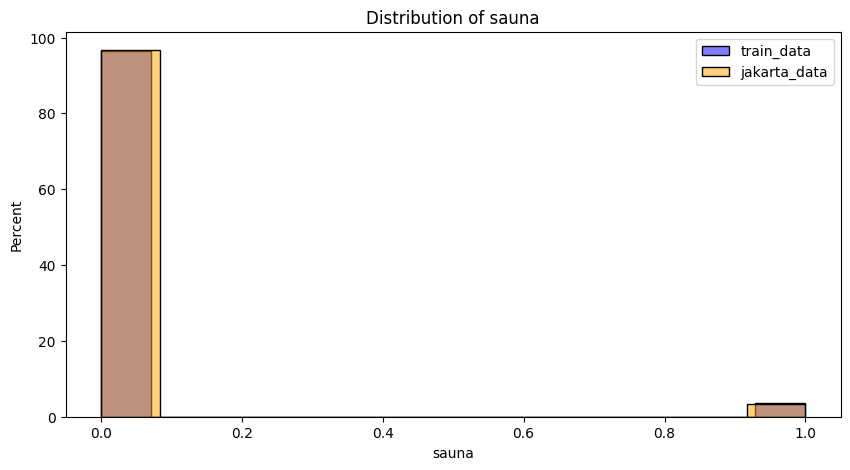

train_data class distribution:
 target_class
0    3793
1     499
Name: count, dtype: int64


KeyError: 'target_class'

In [29]:
# Compare feature distributions
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_data[feature], label='train_data', color='blue', alpha=0.5, stat = 'percent')
    sns.histplot(jakarta_data[feature], label='jakarta_data', color='orange', alpha=0.5, stat = 'percent')
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

In [38]:
jakarta_data['class_area'] = jakarta_data_rescaled['class_area']
jakarta_data.to_csv('jakarta_fitness_area_all_features.csv', index = False)
jakarta_data.to_excel('jakarta_fitness_area_all_features.xlsx', index = False)

In [39]:
jakarta_save = jakarta_data[['link', 'title', 'category', 'address', 'open_hours', 'popular_times',
       'website', 'phone', 'plus_code', 'review_count', 'review_rating',
       'reviews_per_rating', 'latitude', 'longitude', 'cid', 'status',
       'descriptions', 'reviews_link', 'thumbnail', 'timezone', 'price_range',
       'data_id', 'images', 'reservations', 'order_online', 'menu', 'owner',
       'complete_address', 'about', 'user_reviews', 'user_reviews_extended',
       'emails', 'images_links', 'geometry', 'placeid', 'category_complex',
       'category_yoga', 'group_studio', 'pool', 'sauna', 'free_parking_lot',
       'paid_parking_lot', 'free_multi_storey_cp', 'paid_multi_storey_cp',
       'free_street_parking', 'paid_street_parking', 'free_parking',
       'paid_parking', 'parking', 'useful_images', 'large_room_images',
       'text_descriptions',
       'oldest_days', 'years_presence', 'review_freq_per_month',
       'area_building_osm_known', 'class_area']]
jakarta_save = jakarta_save.rename(columns={'oldest_days':'days_presence'})

In [42]:
jakarta_save.to_csv('jakarta_fitness.csv', index = False)
jakarta_save.to_excel('jakarta_fitness.xlsx', index = False)

In [43]:
jakarta_save['class_area'].value_counts()

class_area
0    1613
1      85
Name: count, dtype: int64